(section:extract_magnetopause)=
# Extracting the magnetopause surface from the simulation

The extraction of the magnetopause location from the simulation requires that we understand the information that the output cubes can provide, as well as the various ways the magnetopause can be defined and derived from this information. This can be done either utilizing the electromagnetic fields of the MHD input that was given to the LaTeP model, either the X-ray production itself in the MHD or the LaTeP case.


In [151]:
import numpy as np
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
plt.style.use('dark_background')
from pypalettes import load_cmap
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

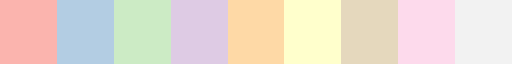

In [242]:
cmap = plt.get_cmap('Pastel1')
plt.get_cmap('Pastel1')

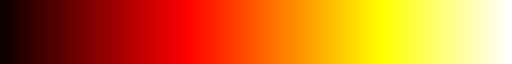

In [185]:
plt.get_cmap('hot')

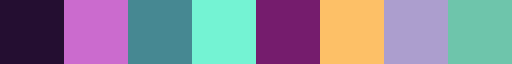

In [137]:
palette = load_cmap('Alexandrite')
palette

# Tangent Hypothesis

The Tangent Fitting Approach is based on the hypothesis that the maximum intensity arc of the SXI images, correspond to the tangent direction of the magnetopause surface. To verify this claim, we will:
1. Extract the magnetopause surface directly from the emissivity cubes.
2. Project its tangent points to the SXI imager's FOV.
3. Extract the maximum intensity arc and compare it to the projection.

To do this, we will work with the output emissivity cubes of the LaTeP simulation, which are in NetCDF file format. The `Cube` class has been defined to read this format, convert it to physical quantities in the GSE frame, and provide functions to transform to other frames (ex. spherical).

Here we load the emissivity cube and transform it to the GSE frame:


In [2]:
import ReadCube as readcube
cube = readcube.Cube("LaTeP_OpenGGCM", step=0.05)
Q_GSE = cube.Q_GSE()

We can also visualize what an observer at infinity would see, along the z and y axis.

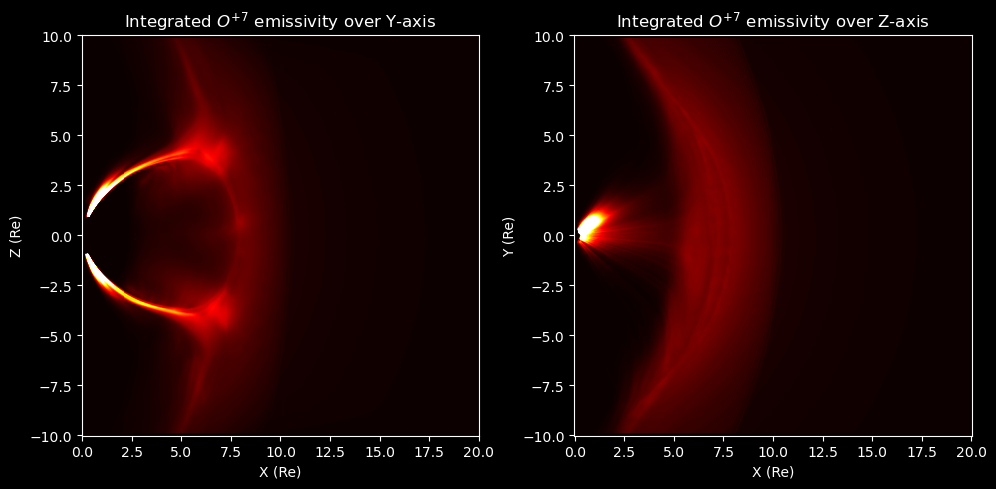

In [158]:
y_integration = cube.get_intengration(axis=1)
z_integration = cube.get_intengration(axis=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].pcolormesh(cube.x_GSE, cube.z_GSE,y_integration.T, cmap='hot',vmax =5e4)
axs[0].set_title("Integrated $O^{+7}$ emissivity over Y-axis")
axs[0].set_xlabel("X (Re)")
axs[0].set_ylabel("Z (Re)")
axs[1].pcolormesh(cube.x_GSE, cube.y_GSE,z_integration.T, cmap='hot',vmax =5e4)
axs[1].set_title("Integrated $O^{+7}$ emissivity over Z-axis")
axs[1].set_xlabel("X (Re)")
axs[1].set_ylabel("Y (Re)")
plt.tight_layout()
plt.show()

## Extracting the Magnetopause surface
### Fitting Shue model to zero-emissivity contour
We can get a first proxy of the cube's magnetopause by taking the zero-emissivity contour of some central slices, since the magnetosphere has almost zero emission. We can fit a Shue model to these contours since it is rotationally symmetric, and get its geometric parameters that best describe the contours.


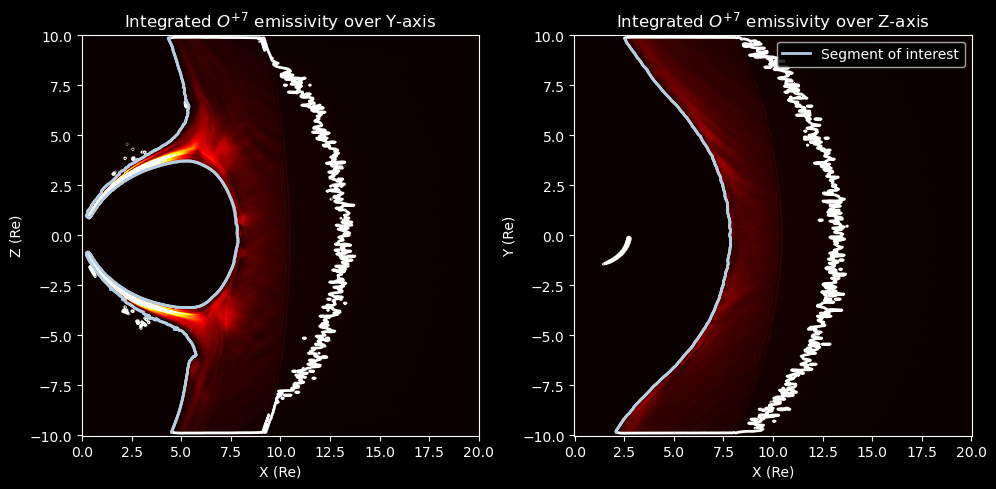

In [246]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pcolormesh(cube.x_GSE, cube.z_GSE,Q_GSE[:,200,:].T, cmap='hot',vmax =1e-4)
cs = axs[0].contour(cube.x_GSE,cube.z_GSE,Q_GSE[:,200,:].T, levels=[1E-6], colors= 'white', linewidths=2)
contour = cs.allsegs[0]
x_zerocontour_xz = contour[0][:,0][2150:]
z_zerocontour_xz = contour[0][:,1][2150:]
axs[0].plot(x_zerocontour_xz,z_zerocontour_xz,linewidth=2, color=cmap(1),label = 'Segment of interest')
axs[0].set_title("Integrated $O^{+7}$ emissivity over Y-axis")
axs[0].set_xlabel("X (Re)")
axs[0].set_ylabel("Z (Re)")

axs[1].pcolormesh(cube.x_GSE, cube.y_GSE,Q_GSE[:,:,200].T, cmap='hot',vmax =1e-4)
cs = axs[1].contour(cube.x_GSE,cube.y_GSE,Q_GSE[:,:,200].T, levels=[1E-6], colors= 'white', linewidths=2)
contour = cs.allsegs[0]
x_zerocontour_xy = contour[0][:,0][2480:]
y_zerocontour_xy = contour[0][:,1][2480:]
axs[1].plot(x_zerocontour_xy,y_zerocontour_xy,linewidth=2, color=cmap(1),label = 'Segment of interest')
axs[1].set_title("Integrated $O^{+7}$ emissivity over Z-axis")
axs[1].set_xlabel("X (Re)")
axs[1].set_ylabel("Y (Re)")

plt.legend()
plt.tight_layout()
plt.show()

Empirical models are typically expressed in spherical coordinates as defined in Section 1.3.1.1. In order to fit the Shue model to the zero contours we transform them this spherical system, and use the `curve_fit` function of `SciPy` to estimate $r_0$ and $\alpha$.

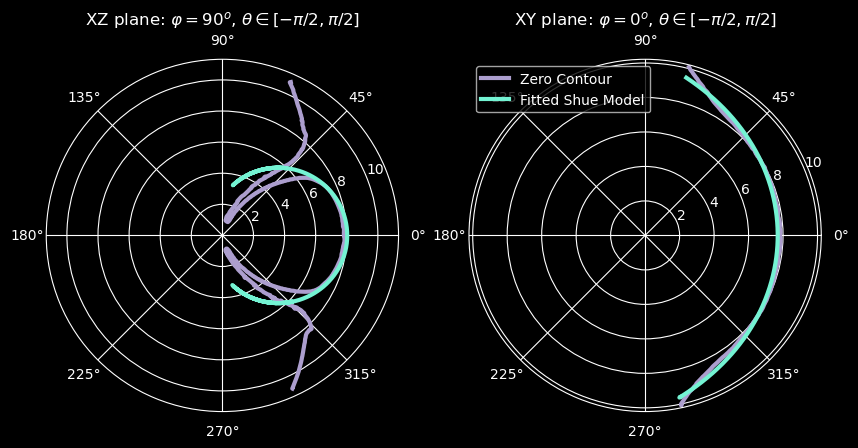

Estimated values from equatorial plane: 
 Subsolar distance: r0 = 7.690695963489819 RE 
 Flaring: a = 0.4412905155362411


In [224]:
def shue(theta, r0, alpha ):
    return r0 * (2 / (1 + np.cos(theta)))**alpha

fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

# XZ plane
r_xz, theta_xz = cube.cart2pol(x_zerocontour_xz,z_zerocontour_xz)
popt, pcov = curve_fit(shue, theta_xz, r_xz, p0=[8,0.5])  # Initial guess: r0=8, alpha=0.5
r0_xz, alpha_xz = popt  # Best-fit parameters
axs[0].plot(theta_xz,r_xz, label='Zero contour',linewidth=3, color=palette(6))
axs[0].set_title("XZ plane: $φ = 90^o$, $θ \in [-π/2,π/2]$")
axs[0].plot(theta_xz,shue(theta_xz,r0_xz,alpha_xz),linewidth=3, color=palette(3),label='Fitted Shue Model')

# XY plane
r_xy, theta_xy = cube.cart2pol(x_zerocontour_xy,y_zerocontour_xy)
popt, pcov = curve_fit(shue, theta_xy, r_xy, p0=[8,0.5])  # Initial guess: r0=8, alpha=0.5
r0_xy, alpha_xy = popt  # Best-fit parameters
axs[1].plot(theta_xy,r_xy, label='Zero Contour',linewidth=3, color= palette(6))
axs[1].set_title("XY plane: $φ= 0^o$, $θ \in [-π/2,π/2]$")
axs[1].plot(theta_xy,shue(theta_xy,r0_xy,alpha_xy),linewidth=3, color=palette(3), label='Fitted Shue Model')

plt.legend()
plt.show()

print(f"Estimated values from equatorial plane: \n Subsolar distance: r0 = {r0_xy} RE \n Flaring: a = {alpha_xy}")

The equatorial plane is giving a good estimation of where the magnetopause is, while the XZ plane cannot be described by such a simplistic model. The flaring parameter is trying to capture the cusps instead of the outer boundary. 

Building the full surface just by using the contour points is challenging due to the unpredictable nature of the contour output of `matplot`. We can always choose the longest contour, but we still have keep only the section of interest in an arbitrary manner.

### Building full surface from radial profiles

To make a full surface we move to a more robust method: transforming the emissivity cube into spherical coordinates, extracting the radial profiles for each θ and φ, and keeping the maximum emissivity points. 

In [160]:
R, Theta, Phi, Q_sph = cube.cartesian_to_spherical(rmax = 15, dtheta = 0.5, dphi = 0.5)

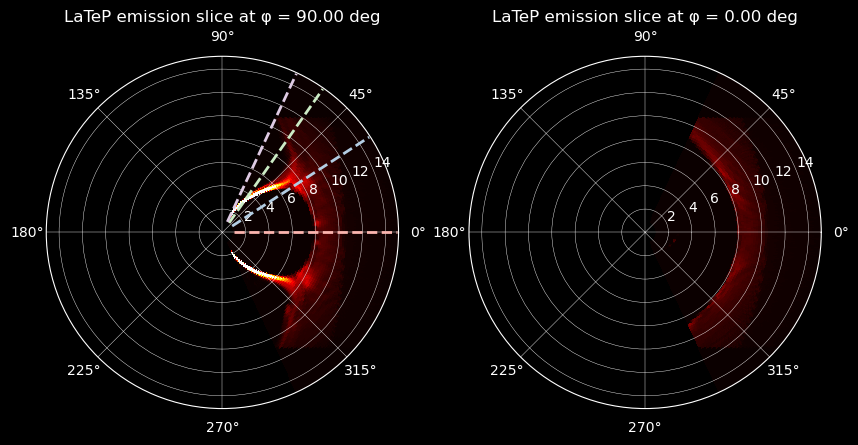

In [243]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

phi_index = 180
axs[0].pcolormesh(Theta[:, :, phi_index], R[:, :, phi_index], Q_sph[:,:,phi_index], cmap='hot',vmax=1e-4)
theta_lines = [0, np.deg2rad(33), np.deg2rad(55), np.deg2rad(65)]
c = 0
for t in theta_lines:
    axs[0].plot([t, t], [R[:, :, phi_index].min(), R[:, :, phi_index].max()], color=cmap(c), linestyle='--', linewidth=2)
    c+=1
axs[0].set_title("LaTeP emission slice at φ = {:.2f} deg".format(np.degrees(Phi[0, 0, phi_index])))
axs[0].grid(which='major', color='white', linewidth=0.3)

phi_index = 0
axs[1].pcolormesh(Theta[:, :, phi_index], R[:, :, phi_index], Q_sph[:,:,phi_index], cmap='hot',vmax=1e-4)
axs[1].set_title("LaTeP emission slice at φ = {:.2f} deg".format(np.degrees(Phi[0, 0, phi_index])))
axs[1].grid(which='major', color='white', linewidth=0.3)


plt.show()

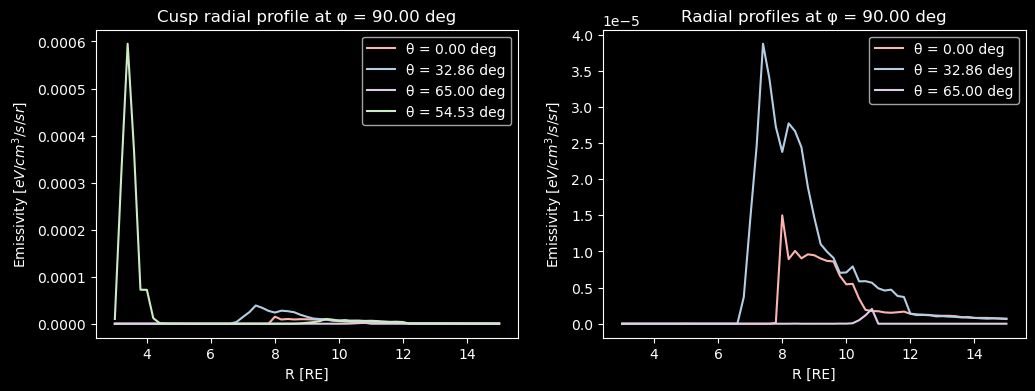

In [245]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ph = 180
th = 180
axs[0].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(0))
th = -90
axs[0].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(1))
th = -1
axs[0].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(3))
th = -30
axs[0].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(2))
axs[0].set_title(f"Cusp radial profile at φ = {np.degrees(Phi[th, 0, ph]):.2f} deg")
axs[0].set_xlabel("R [RE]")
axs[0].set_ylabel("Emissivity [$eV/cm^3/s/sr$]")
axs[0].legend()

th = 180
axs[1].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(0))
th = -90
axs[1].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(1))
th = -1
axs[1].plot(R[th,10:,ph],Q_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(3))
axs[1].set_title(f"Radial profiles at φ = {np.degrees(Phi[th, 0, ph]):.2f} deg")
axs[1].set_xlabel("R [RE]")
axs[1].set_ylabel("Emissivity [$eV/cm^3/s/sr$]")
axs[1].legend()

plt.show()

In [247]:
cube_MHD = readcube.Cube("MHD_OpenGGCM", step=0.05)
Q_MHD_GSE = cube_MHD.Q_GSE()
R, Theta, Phi, Q_MHD_sph = cube_MHD.cartesian_to_spherical(rmax = 15, dtheta = 0.5, dphi = 0.5)

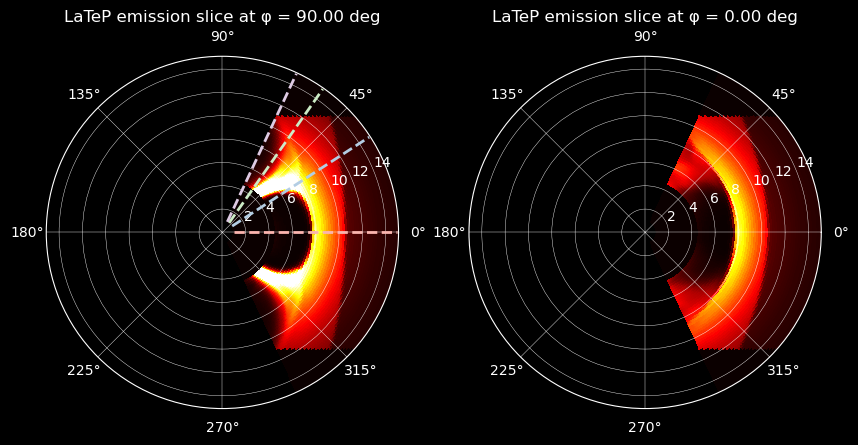

In [250]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})

phi_index = 180
axs[0].pcolormesh(Theta[:, :, phi_index], R[:, :, phi_index], Q_MHD_sph[:,:,phi_index], cmap='hot',vmax=1e-6)
theta_lines = [0, np.deg2rad(33), np.deg2rad(55), np.deg2rad(65)]
c = 0
for t in theta_lines:
    axs[0].plot([t, t], [R[:, :, phi_index].min(), R[:, :, phi_index].max()], color=cmap(c), linestyle='--', linewidth=2)
    c+=1
axs[0].set_title("LaTeP emission slice at φ = {:.2f} deg".format(np.degrees(Phi[0, 0, phi_index])))
axs[0].grid(which='major', color='white', linewidth=0.3)

phi_index = 0
axs[1].pcolormesh(Theta[:, :, phi_index], R[:, :, phi_index], Q_MHD_sph[:,:,phi_index], cmap='hot',vmax=1e-6)
axs[1].set_title("LaTeP emission slice at φ = {:.2f} deg".format(np.degrees(Phi[0, 0, phi_index])))
axs[1].grid(which='major', color='white', linewidth=0.3)


plt.show()

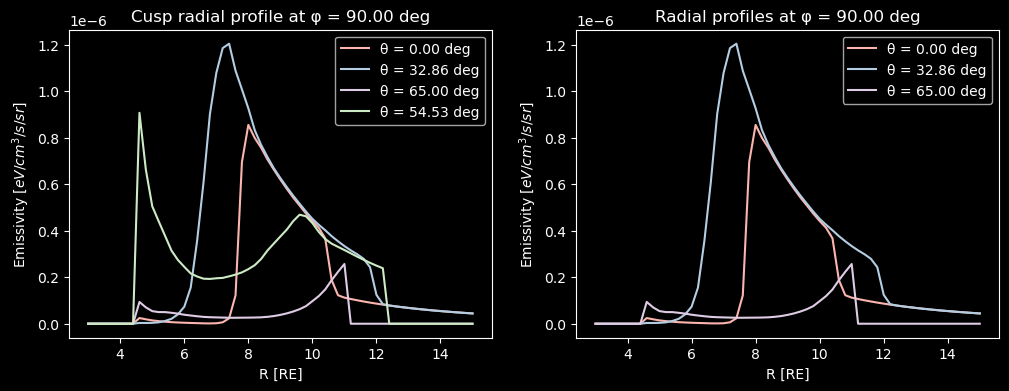

In [251]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ph = 180
th = 180
axs[0].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(0))
th = -90
axs[0].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(1))
th = -1
axs[0].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(3))
th = -30
axs[0].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(2))
axs[0].set_title(f"Cusp radial profile at φ = {np.degrees(Phi[th, 0, ph]):.2f} deg")
axs[0].set_xlabel("R [RE]")
axs[0].set_ylabel("Emissivity [$eV/cm^3/s/sr$]")
axs[0].legend()

th = 180
axs[1].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(0))
th = -90
axs[1].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(1))
th = -1
axs[1].plot(R[th,10:,ph],Q_MHD_sph[th,10:,ph], label= f"θ = {np.degrees(Theta[th, 0, ph]):.2f} deg", color=cmap(3))
axs[1].set_title(f"Radial profiles at φ = {np.degrees(Phi[th, 0, ph]):.2f} deg")
axs[1].set_xlabel("R [RE]")
axs[1].set_ylabel("Emissivity [$eV/cm^3/s/sr$]")
axs[1].legend()

plt.show()